## Initial data solver using relaxation

We try to solve the time symmetric initial data when given a $ρ$ field on a cube. 
We put Robin boudary conditions.

Thus we shall be solving:

$$
ψ_{tt} = \Delta ψ + ψ^5 ρ \;\;\;\; \vec{x}\cdot \nabla ψ + (1-ψ) = 0
$$

$$
\rho = |phi_t|^2 + V + \psi^{-4}|\nabla \psi|^2
$$

Using second order finite differences inside the domain and first order at the boudaries we get for the boundary values (which are not evolved):

For boundary conditions we shall put an outgoing wave, but taking into account that we want a radial wave and that something which at first order should be a monopolar field.

$$
ψ_t = (x^i\partial_i ψ - (ψ - ψ_0))/r
$$ 
Same for the time derivative, but that part should be unnessary becuse this should decay to a static solution.

The solution we are seeking is of the form of an outgoing wave plus a static solution, the one we are after. It well behave as a monopole at large distance, plus a constant.

$$
\psi(t,x) =\frac{f(t-r) + M}{r} + \psi_0
$$

Thus we have, 
$$
\partial_t \psi = \frac{f'(t-r)}{r}, \;\;\;\;\; \frac{\vec{x}\cdot \nabla \psi}{r} = -f'/r - f/r^2 - M/r^2 
$$

therefore asymtotically we should have, 
$$ 
\partial_t \psi = - \frac{\vec{x}\cdot \nabla \psi}{r} - (f+M)/r^2 = - \frac{\vec{x}\cdot ∇\psi}{r} - (\psi - \psi_0)/r 
$$

The equation for $\xi := \alpha \psi$ is:

$$
\xi_{tt} = \Delta \xi + \xi ψ^4 (\rho + 2S) \;\;\;\; \vec{x}\cdot \nabla ψ + (1-ψ) = 0
$$

Where

$$
S = - \psi^{-4}|\nabla \phi|^2 + 3(\pi^2 - V) \;\;\; \rho + 2S = 7\pi^2 - 5 V - \psi^{-4}|\nabla \phi|^2
$$

In [1]:
using SummationByPartsOperators
using Plots
using Revise
using Distributions
using FFTW
using LinearAlgebra
using Base.Threads
using HDF5
 
#includet("../PIC/PIC-1D/aux_functions/aux_functions.jl")
includet("../PIC-1D/aux_functions/aux_functions.jl")
includet("local_aux_functions.jl")



First run inidat.ipynb and get the data


In [2]:
data = h5open("data_3d_h_step_cut_small.h5", "r")

🗂️ HDF5.File: (read-only) data_3d_h_step_cut_small.h5
├─ 🔢 coord0
├─ 🔢 coord1
├─ 🔢 coord2
├─ 🔢 nvars
├─ 🔢 var0
├─ 🔢 var1
├─ 🔢 var2
├─ 🔢 var3
├─ 🔢 var4
├─ 🔢 var5
└─ 🔢 var6

In [3]:
J_in = size(data["var6"])
Box_x_in = [read(data["coord0"])[1], read(data["coord0"])[end],read(data["coord1"])[1], read(data["coord1"])[end],read(data["coord2"])[1], read(data["coord2"])[end]];
J = (3).*J_in
Box_x = 3*Box_x_in;
dx = differentials(Box_x,J)
V = volume(Box_x)
m = 1
m2 = m^2


Dx = derivative_operator(MattssonNordström2004(), derivative_order = 1, accuracy_order = 2, xmin = Box_x[1], xmax = Box_x[2], N=J[1])
Dy = derivative_operator(MattssonNordström2004(), derivative_order = 1, accuracy_order = 2, xmin = Box_x[3], xmax = Box_x[4], N=J[2])
Dz = derivative_operator(MattssonNordström2004(), derivative_order = 1, accuracy_order = 2, xmin = Box_x[5], xmax = Box_x[6], N=J[3])
D2x = derivative_operator(MattssonNordström2004(), derivative_order = 2, accuracy_order = 2, xmin = Box_x[1], xmax = Box_x[2], N=J[1])
D2y = derivative_operator(MattssonNordström2004(), derivative_order = 2, accuracy_order = 2, xmin = Box_x[3], xmax = Box_x[4], N=J[2])
D2z = derivative_operator(MattssonNordström2004(), derivative_order = 2, accuracy_order = 2, xmin = Box_x[5], xmax = Box_x[6], N=J[3])
x = collect(SummationByPartsOperators.grid(Dx))
y = collect(SummationByPartsOperators.grid(Dy))
z = collect(SummationByPartsOperators.grid(Dz));

In [4]:
J

(333, 333, 333)

In [5]:
π2 = embed_source(read(data["var4"]),J);
#heatmap(x,y,π2[:,:,J[3]÷2], aspectratio=1)
∇2 = embed_source(read(data["var5"]),J);
#heatmap(x,y,∇2[:,:,J[3]÷2], aspectratio=1)
V = embed_source(read(data["var6"]),J);
#heatmap(x,y,V[:,:,J[3]÷2], aspectratio=1)

#heatmap(π2[:,:,(J[3]+1)÷2])

In [6]:
n_fields = 4 # the field and its derivative 
u = zeros(n_fields,J...)
du = similar(u)
d2 = zeros(2,J...);
#dxu = similar(u);
#dyu = similar(u);
#dzu = similar(u);

In [14]:
T = 200.0
data_step = 10 #place where to extract data
int_steps = 100
M = data_step * int_steps + 1
@show dt = T/(M-1)


v = zeros(n_fields,data_step+1 ,J...)
τ = 1.0 #damping must be positive here
par = (1.0, 1.0, τ) # (a, b, τ)
#par_F = (x,y,z,dxu,dyu,dzu,Dx,Dy,Dz,D2x,D2y,D2z,d2,dx,ρ,J, par)
dxu_x = zeros(2,n_fields,J[2],J[3]); dyu_x = copy(dxu_x); dzu_x = copy(dxu_x)
dxu_y = zeros(2,n_fields,J[1],J[3]); dyu_y = copy(dxu_y); dzu_y = copy(dxu_y)
dxu_z = zeros(2,n_fields,J[1],J[2]); dyu_z = copy(dxu_z); dzu_z = copy(dxu_z)
coors = (x,y,z)
boundary_derivs = (dxu_x,dyu_x,dzu_x,dxu_y,dyu_y,dzu_y,dxu_z,dyu_z,dzu_z)
derivs = (Dx,Dy,Dz,D2x,D2y,D2z)
ρ = 0.01 .*(π2,∇2,V)
par_FCR = (coors,boundary_derivs,derivs,d2,dx,ρ,J,n_fields,par)
norms = zeros(n_fields,M)



dt = T / (M - 1) = 1.0


4-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN

In [10]:
@show size(u);
@show size(π2)
@show norm(π2)/prod(J)

size(u) = (4, 333, 333, 333)
size(π2) = (333, 333, 333)
norm(π2) / prod(J) = 9.355632708121528e-7


9.355632708121528e-7

In [15]:
u[1,:,:,:] .= 1.0
u[2,:,:,:] .= 0.0
u[3,:,:,:] .= 1.0
u[4,:,:,:] .= 0.0

norms[:,1] = [norm(u[1,:,:,:]),norm(u[2,:,:,:]),norm(u[3,:,:,:]),norm(u[4,:,:,:])]/prod(J)

global t = 0.0
for m in 1:data_step-1
    for mm in 1:int_steps
        RK4_Step!(FCR_Full,u,t,dt,par_FCR)
        global t = t + dt
    end    
    norms[:,m+1] = [norm(u[1,:,:,:]),norm(u[2,:,:,:]),norm(u[3,:,:,:]),norm(u[4,:,:,:])]/prod(J)
    println("t = $t, m = $m, norm u_1 = $(norms[1,m]) norm u_2 = $(norms[2,m]), norm u_3 = $(norms[3,m]) norm u_4 = $(norms[4,m])")
    v[:,m+1,:,:,:] = u[:,:,:,:]
    
end

t = 1.0, m = 1, norm u_1 = 6076.6797677679215 norm u_2 = 0.0, norm u_3 = 6076.6797677679215 norm u_4 = 0.0
t = 2.0, m = 2, norm u_1 = 6076.796182466308 norm u_2 = 1.9131790282729604, norm u_3 = 6076.332172648948 norm u_4 = 6.109764030612918
t = 3.0, m = 3, norm u_1 = 6077.035924302822 norm u_2 = 2.3724660917962233, norm u_3 = 6075.627028807323 norm u_4 = 7.1325102335480555
t = 4.0, m = 4, norm u_1 = 6077.3259012750505 norm u_2 = 2.5200015500923025, norm u_3 = 6074.791136744649 norm u_4 = 7.422668542474143
t = 5.0, m = 5, norm u_1 = 6077.638717706604 norm u_2 = 2.5877754224676157, norm u_3 = 6073.909032786982 norm u_4 = 7.516360050883083
t = 6.0, m = 6, norm u_1 = 6077.964024611586 norm u_2 = 2.624217290226544, norm u_3 = 6073.01290865711 norm u_4 = 7.522250946373885
t = 7.0, m = 7, norm u_1 = 6078.2979952793585 norm u_2 = 2.6536822669886506, norm u_3 = 6072.114800734496 norm u_4 = 7.511249145512806
t = 8.0, m = 8, norm u_1 = 6078.639312057821 norm u_2 = 2.682179294063175, norm u_3 = 60

In [22]:
norms

4×11 Matrix{Float64}:
 6076.68  6076.8      6077.04     6077.33     …  6078.99     6079.34     0.0
    0.0      1.91318     2.37247     2.52           2.71264     2.75726  0.0
 6076.68  6076.33     6075.63     6074.79        6070.33     6069.44     0.0
    0.0      6.10976     7.13251     7.42267        7.48643     7.59751  0.0

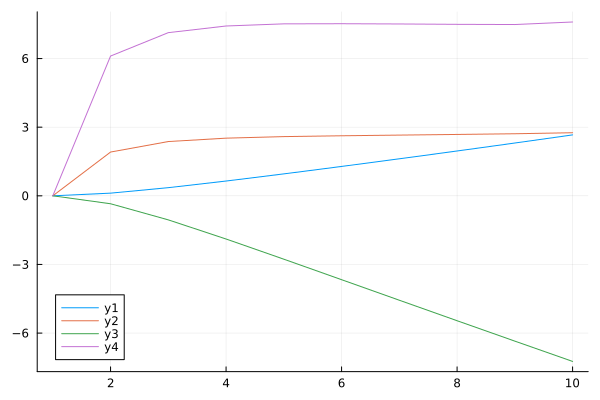

In [24]:
plot(norms[1,1:end-1].-norms[1,1])
plot!(norms[2,1:end-1])
plot!(norms[3,1:end-1] .-norms[3,1])
plot!(norms[4,1:end-1])

[ Info: Saved animation to /home/reula/Julia/boson/carlos_phi_e.gif


Plots.AnimatedGif("/home/reula/Julia/boson/carlos_phi_e.gif")
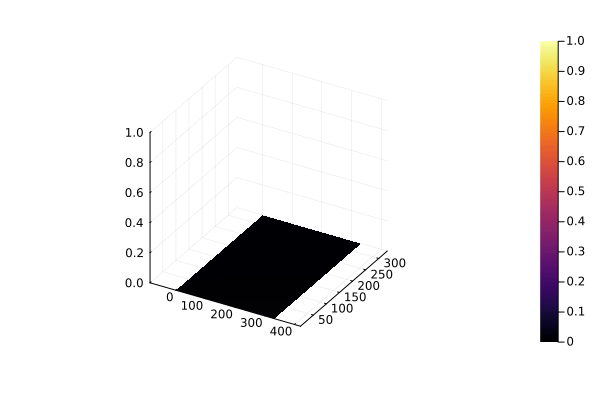

In [26]:
anim = @animate for i ∈ 1:1:M
    surface(v[1,i,:,:,(J[3]+1)÷2],aspectratio=1)
end

gif(anim, "carlos_phi_e.gif", fps = 10)